In [1]:
import numpy as np
from fair.constants.general import M_ATMOS
from fair.constants.molwt import AIR as M_AIR   # this will be moved
from fair.constants import molwt
import pint

unit = pint.UnitRegistry()
unit.define('volume_mixing_ratio = [vmr] = vmr')
unit.define('percent = 0.01 * volume_mixing_ratio = pc')
unit.define('parts_per_billion = 1e-9 * volume_mixing_ratio = ppb')
unit.define('parts_per_trillion = 1e-12 * volume_mixing_ratio = ppt')
emissions = 10 * unit.Mt / unit.year
M_ATM = M_ATMOS * unit.kg
m_ch4 = molwt.CH4 * unit.g / unit.mol
M_AIR = molwt.AIR * unit.g / unit.mol
timestep = 1 * unit.year

print(emissions)
print(M_ATM)
print(m_ch4, M_AIR)

# this is per year
print((emissions/M_ATM * M_AIR/m_ch4 * unit.year * unit.vmr).to_base_units().to('ppb'))

10.0 megametric_ton / year
5.1352e+18 kilogram
(<Quantity(16.04, 'gram / mole')>, <Quantity(28.97, 'gram / mole')>)
3.51711661802 parts_per_billion


In [2]:
library = ['CO2', 'CH4', 'N2O']

class Species:
 
    def __init__(self, name=None, efficacy=1):
        self.name = name
        self.efficacy = efficacy
        
        #if name in library:   # pandas datatable of stats or a csv?
            # load up all the stuff above
            # self.lifetime = library[name].lifetime
            # self.radiative_efficiency = library[name].radiative_efficiency and so on
    
    def set_emissions(self, anthropogenic, natural=0, timestep=unit.year):
        self.emissions = anthropogenic
        self.natural_emissions = natural
        self.timestep = timestep
        return Emissions(anthropogenic, natural, timestep)
        
    def set_lifetime(self, lifetime):
        self.lifetime = lifetime
        
    def calculate_concentrations(self):
        # for GHGs with no temperature feedback or inter-species dependence
        emissions = self.emissions + self.natural_emissions
        nt = len(emissions)   # ensures that either emissions or natural_emissions are array - still need to check it is 1D
        concentrations = np.ones(nt) * np.nan * unit.vmr

        def _forward(c0, e0, e1, ts, lt, vm):   # put this in its own module and import
            c1 = c0 - c0 * (1.0 - np.exp(-ts/lt)) + 0.5 * ts * (e1 + e0) * vm
            return c1
            
        concentrations[0] = _forward(self.concentration_t0, emissions[0], emissions[0], 
                                     timestep, self.lifetime, self.kg_to_vmr)
        for t in range(1,nt):
            concentrations[t] = _forward(concentrations[t-1], emissions[t-1], emissions[t], 
                                         timestep, self.lifetime, self.kg_to_vmr)

        self.concentrations = concentrations
        return Concentrations(concentrations)

    def calculate_forcing(self, scale=1):
        # need checks to determine that scale is scalar or array with same length as 
        self.radiative_forcing = (self.concentrations - self.reference_concentration) * self.radiative_efficiency * scale
        self.radiative_forcing.ito(unit.watt / unit.m**2)
        return RadiativeForcing(self.radiative_forcing)

    
class GreenhouseGas(Species):
    def __init__(self, radiative_efficiency, reference_concentration, concentration_t0, molecular_weight):
        self.radiative_efficiency    = radiative_efficiency
        self.reference_concentration = reference_concentration
        self.concentration_t0        = concentration_t0
        self.molecular_weight        = molecular_weight
        self.kg_to_vmr               = M_AIR/self.molecular_weight / M_ATM * 1.0 * unit.vmr
    
        
class Emissions:
    def __init__(self, anthropogenic, natural, timestep):
        self.emissions=anthropogenic
        self.natural_emissions=natural
        self.timestep=timestep
        
        
class Concentrations:
    def __init__(self, concentrations):
        self.concentrations = concentrations
    
    
class RadiativeForcing:
    def __init__(self, radiative_forcing):
        self.radiative_forcing = radiative_forcing
        
        
class Temperature:
    def __init__(self):
        pass

In [3]:
CFC12 = GreenhouseGas(radiative_efficiency=0.32 * unit.watt / unit.m**2 / unit.ppb,
                   reference_concentration=0 * unit.ppt,
                   concentration_t0=0 * unit.ppt,
                   molecular_weight=120.91 * unit.g / unit.mol)
CFC12.set_emissions(np.ones(1000)*300 * unit.kilometric_tons / unit.year,
                  natural = 0.00 * unit.kilometric_tons / unit.year)
CFC12.set_lifetime(100 * unit.years)
CFC12.calculate_concentrations()

<__main__.Concentrations instance at 0x00000000106EBA88>

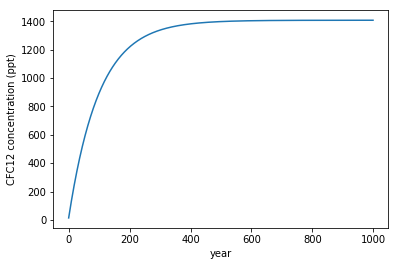

In [4]:
%matplotlib inline
import matplotlib.pyplot as pl
years = np.arange(1000) * unit.year
pl.plot(years, CFC12.concentrations.to('ppt'))
pl.xlabel('year')
pl.ylabel('CFC12 concentration (ppt)');

In [5]:
CFC12.calculate_forcing()

<__main__.RadiativeForcing instance at 0x00000000106E5648>

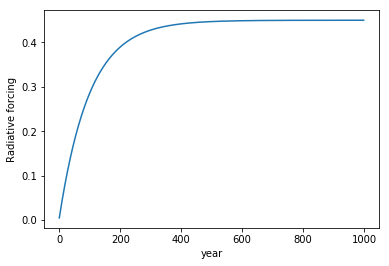

In [6]:
pl.plot(years, CFC12.radiative_forcing.to('W/m**2'))
pl.xlabel('year')
pl.ylabel('Radiative forcing');

Text(0,0.5,'temperature')

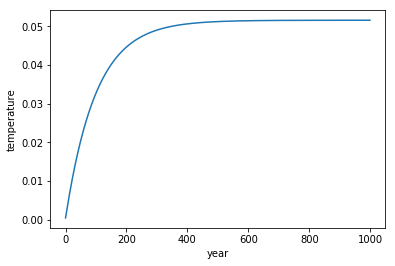

In [7]:
# this I think is currently wrong but has not been followed through fully from fair 1.0 - just illustrative
def calculate_temperature(radiative_forcing,
                          efficacy=1,
                          d=np.array([239, 4.1]) * unit.year,
                          q=np.array([0.33,0.41]) * unit.K * unit.m**2 / unit.watt,
                          timestep = 1 * unit.year
                         ):
    # radiative forcing needs to be smartly handled here
    # radiative_forcing = sum_over_all_species_forcing
    nbox = len(q)
    nt = len(radiative_forcing)
    T_j = np.ones((nt, nbox)) * np.nan * unit.K
    T   = np.ones((nt)) * np.nan * unit.K
    
    # Update the thermal response boxes
    T_j[0,:] = (q/d)*radiative_forcing[0] * efficacy * timestep

    # Sum the thermal response boxes to get the total temperature anomaly
    T[0]=np.sum(T_j[0,:],axis=-1)
    
    for t in range(1,nt):
        # Update the thermal response boxes
        T_j[t,:] = T_j[t-1,:]*(1 - np.exp(-timestep/d)) + q * (1-np.exp((-timestep)/d)) * radiative_forcing[t] * efficacy
        # Sum the thermal response boxes to get the total temperature
        T[t]=np.sum(T_j[t,:],axis=-1)
    return T
        
T = calculate_temperature(CFC12.radiative_forcing)
pl.plot(years, T)
pl.xlabel('year')
pl.ylabel('temperature')